# Linear Regression

So far in these notes, we have almost exclusively considered the *classification problem*: given some data with categorical labels, we aim to learn patterns in the data that will allow us to predict new labels for new unseen data. In the *regression  problem*, we instead aim to learn patterns in the data that will allow us to predict a *quantitative* variable. If you want to predict the future price of a stock, the GPA of a Middlebury College student, or the number of wildfires in Vermont per year, you need to solve a regression problem. 

In these lecture notes we'll focus on the *linear* regression problem and some of its extensions. Linear regression is an easy object of focus for us because it can be formulated in the framework of empirical risk minimization that we have recently been developing. In its most fundamental form, linear regression is the task of fitting a line to a cloud of points that display some kind of trend. Here's the simple picture: 

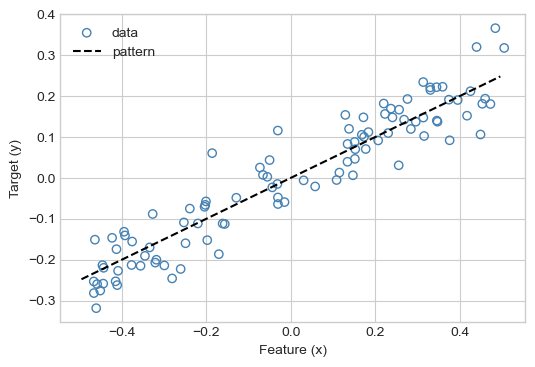

In [1]:
#| code-fold: true

import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def regression_data(n = 100, w = torch.Tensor([-0.7, 0.5]), phi = lambda x: x, x_max = 1):

    X = torch.zeros(n, 2)
    x = torch.rand(n)*x_max
    x, ix = torch.sort(x)
    X[:, 1] = x
    X[:, 0] = torch.ones(n)

    X = X - X.mean(dim = 0,keepdims = True)


    y = phi(X)@w + 0.05*torch.randn(n)
    y = y - y.mean()
    return X, y


def plot_regression_data(X, y, w = None, phi = lambda x: x, pattern_label = "pattern", ax = None, legend = True, xlabel = True, ylabel = True, title = None):
    
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize = (6, 4))

    if xlabel: 
        labels = ax.set(xlabel = "Feature (x)")
    if ylabel: 
        labels = ax.set(ylabel = "Target (y)")
    if title: 
        t = ax.set(title = title)


    ax.scatter(X[:,1], y, facecolors = "none", edgecolors = "steelblue", label = "data")
    if w is not None: 
        m_points = 1001
        X_ = torch.zeros(m_points, 2)
        x = torch.linspace(X[:,1].min().item()-0.01, X[:,1].max().item()+0.01, m_points)
        X_[:,1] = x
        X_[:, 0] = torch.ones(m_points)
        X_ = X_ - X_.mean(dim = 0,keepdims = True)

        y_ = phi(X_)@w 
        ax.plot(X_[:,1], y_, linestyle = "dashed", color = "black", label = pattern_label)
        if legend:
            ax.legend()



w = torch.Tensor([0.4, 0.5])

X, y = regression_data(w = w)
plot_regression_data(X, y, w = w)

Our aim is to approximately learn the pattern when we are allowed only to observe the points. 

Theoretically, linear regression is *just another kind of empirical risk minimization*. In practice, it has a few extra tricks. 

## Linear Regression as Empirical Risk Minimization

[Last time](30-features-regularization.qmd), we studied the most general form of the empirical risk minimization problem: 

$$
\DeclareMathOperator*{\argmin}{argmin}
\begin{aligned}
    \hat{\mathbf{w}} = \argmin_{\mathbf{w}} L(\mathbf{w}) = \argmin_{\mathbf{w}} \frac{1}{n} \sum_{i = 1}^n \ell (\langle\mathbf{w}, \phi(\mathbf{x}_i)\rangle, y_i) + \lambda R(\mathbf{w})\;. 
\end{aligned}
$${#eq-regularized-erm}

Here, $\ell$ is the *per-observation loss function*, $\phi$ is a *feature map*, $R(\mathbf{w})$ is a regularizing term. When studying convexity, we introduced several different choices of $\ell$, including the 0-1 loss, logistic loss, and hinge loss. 

Doing linear regression is as simple as choosing a different loss function. The most common choice is the square loss: 

$$
\begin{aligned}
    \ell(s, y) = (s - y)^2\;. 
\end{aligned}
$$

::: {.callout-note}

Check that this function is convex as a function of $s$! 

:::


With this choice, empirical risk minimization becomes *least-squares linear regression*, with loss function 

$$
\begin{aligned}
    L(\mathbf{w}) = \underbrace{\frac{1}{n} \sum_{i = 1}^n (\langle\mathbf{w}, \phi(\mathbf{x}_i)\rangle - y_i)^2}_{\text{mean-squared error}} + \lambda R(\mathbf{w})\;. 
\end{aligned}
$${#eq-least-squares}

The first term in this expression is the mean-squared error (MSE). Motivation via the MSE is the most common way that least-squares linear regression is motivated in statistics courses. 

One can use the second-derivative test to check that the square loss is convex in $s$, which means that all our standard theory from convex risk minimization translates to this setting as well. Gradient descent is one good method to learn the model and find $\hat{\mathbf{w}}$, although there are many other good ways as well. 

## Matrix-Vector Formulation

It is possible to write @eq-least-squares much more simply using matrix-vector notation: [Here, $\lVert \mathbv{v} \rVert_2^2 = \sum_{i}v_i^2$ is the squared Euclidean norm.]{.aside}

$$
\begin{aligned}
    L(\mathbf{w}) = \frac{1}{n} \lVert\phi(\mathbf{X})\mathbf{w} - \mathbf{y}\rVert_2^2 + \lambda R(\mathbf{w})\;. 
\end{aligned}
$${#eq-least-squares-matrix}

By rules of multivariable differentiation, the gradient of the empirical risk $L(\mathbf{w})$ is [We looked at some gradients for the regularization term $R(\mathbf{w})$ in [previous notes](30-features-regularization.qmd).]{.aside}

$$
\nabla L(\mathbf{w}) = \frac{2}{n}\phi(\mathbf{X})^T(\phi(\mathbf{X})\mathbf{w} - \mathbf{y}) + \lambda \nabla R(\mathbf{w})\;.
$${#eq-gradient}

Using this gradient for a gradient-descent scheme would be a perfectly reasonable way to go about solving a least-squares linear regression problem. 

### Ridge Regression

Suppose for a moment that we choose $R(\mathbf{w}) = \lVert \mathbf{w} \rVert_2^2$, the $\ell_2$ or *ridge* penalty. [When using this regularizing term, we usually need to assume that, for each feature $j$, $\sum_{i = 1}^n\phi_{ij}(\mathbf{X}) = 0$. This is called *column centering* and can be achieved simply by subtracting the column mean from each entry of $\mathbf{X}$. The reason we need to do this is that it guarantees that the weight of the constant feature is $0$, which ensures that it's not a problem for us to include it in the regularization term $R(\mathbf{w})$. The function `regression_data` from above always produces column-centered data.] 
In order to make the math work out nicely, it's convenient to assume that $\lambda = \Lambda / n$ for some $\Lambda$. 

In this case, the empirical risk objective function is 

$$
\begin{aligned}
    L(\mathbf{w}) &= \frac{1}{n}\left[ \lVert \Phi(\mathbf{X}) \mathbf{w} - \mathbf{y} \rVert_2^2 + \Lambda \lVert \mathbf{w}\rVert_2^2 \right] \\
           &= \underbrace{\frac{1}{n} \sum_{i = 1}^n (\langle\mathbf{w}, \phi(\mathbf{x}_i)\rangle - y_i)^2} + \frac{\Lambda}{n} \sum_{j = 1}^p w_{j}^2  \;. 
\end{aligned}
$$

The gradient of the loss function is 
$$
\nabla L(\mathbf{w}) = \frac{2}{n}\phi(\mathbf{X})^T(\phi(\mathbf{X})\mathbf{w} - \mathbf{y}) + 2\frac{\Lambda}{n} \mathbf{w}\;.
$${#eq-gradient}

Unusually in this class, we can actually find the minimum of $L(\mathbf{w})$ using the first-derivative test: we set $\nabla L(\hat{\mathbf{w}}) = \mathbf{0}$ and solve for $\hat{\mathbf{w}}$. This equation is: 

$$
\mathbf{0} = \frac{2}{n}\phi(\mathbf{X})^T(\phi(\mathbf{X})\mathbf{w} - \mathbf{y}) + 2\frac{\Lambda}{n}  \mathbf{w}\;.
$$

We can cancel the $\frac{2}{n}$s and move everything that depends on $\mathbf{w}$ to one side of the equation: 

$$
- \phi(\mathbf{X})^T\phi(\mathbf{X})\hat{\mathbf{w}} - \Lambda \hat{\mathbf{w}}  = -\phi(\mathbf{X})^T\mathbf{y} \;.
$$

or 

$$
\left[\phi(\mathbf{X})^T\phi(\mathbf{X}) + \Lambda \mathbf{I} \right]\hat{\mathbf{w}}  = \phi(\mathbf{X})^T\mathbf{y} \;.
$$

This is a matrix-vector equation of the familiar form $\mathbf{A}\mathbf{x} = \mathbf{b}$, where $\mathbf{A} = \phi(\mathbf{X})^T\phi(\mathbf{X}) + \Lambda \mathbf{I} \in \mathbb{R}^{p \times p}$, $\mathbf{x} = \mathbf{w} \in \mathbb{R}^{p}$, and $\mathbf{b} = \phi(\mathbf{X})^T\mathbf{y} \in \mathbb{R}^p$. 

You may remember from linear algebra that this equation has exactly one solution *provided that the matrix $\mathbf{A} = \phi(\mathbf{X})^T\phi(\mathbf{X}) + \Lambda \mathbf{I}$ has full rank ($p$ linearly independent rows/columns), which implies that it is invertible. This is guaranteed to be the case provided that $\Lambda > 0$. So, we can invert the matrix and find that the optimal choice of $\hat{vw}$ is 

$$
\begin{aligned}
    \hat{\mathbf{w}} = \left[\phi(\mathbf{X})^T\phi(\mathbf{X}) + \Lambda \mathbf{I} \right]^{-1} \phi(\mathbf{X})^T\mathbf{y}\;. 
\end{aligned}
$${#eq-ridge-regression-closed}

Let's see this formula in action. We'll start by fitting a model to the linear trend that we saw in the beginning of these notes: 

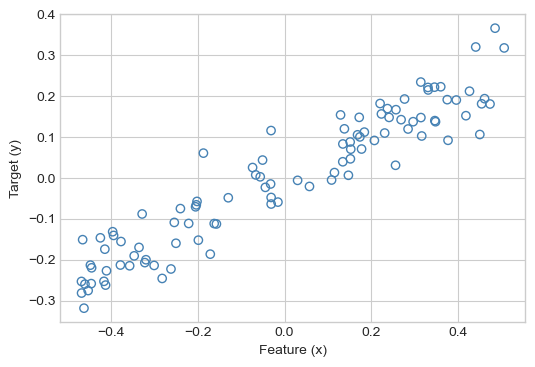

In [2]:
plot_regression_data(X, y)

Now we can implement @eq-ridge-regression-closed. 

In [3]:
#---
def ridge_regression(X, y, lam = 1.0):
    p = X.size(1)
    w_hat = torch.inverse(X.T@X + lam*torch.eye(p))@X.T@y
    return w_hat
#---

To assess the quality of our fit, let's measure the MSE (the unregularized term of the empirical risk): 

In [4]:
#---
def mse(X, y, w):
    return ((X@w - y)**2).mean()
#---

Training our model is as simple as calling the function we implemented. 

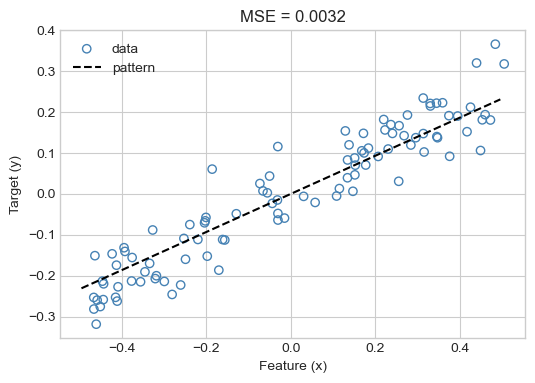

In [5]:
#---
w_hat = ridge_regression(X, y, lam = 1.0)
plot_regression_data(X, y, w = w_hat, title = f"MSE = {mse(X, y, w_hat):.4f}")
#---

How did we do on the test data? 

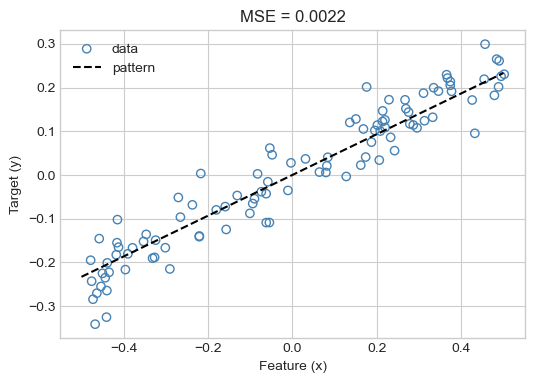

In [6]:
#---
X_test, y_test = regression_data(100, w)
plot_regression_data(X_test, y_test, w = w_hat, title = f"MSE = {mse(X_test, y_test, w_hat):.4f}")
#---

Not bad! The MSE is similar on the training and testing data, suggesting that we have not overfit. 

The effect of increasing $\Lambda$ is to reduce the values of the entries $\hat{\mathbf{w}}$. Choosing $\Lambda$ to be too large can lead to undesirable fits: 

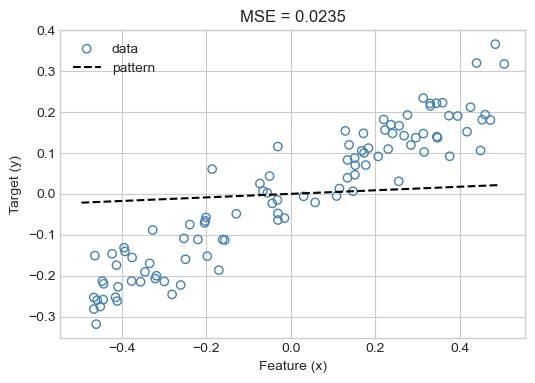

In [7]:
#---
w_hat = ridge_regression(X, y, lam = 100.0)
plot_regression_data(X, y, w = w_hat, title = f"MSE = {mse(X, y, w_hat):.4f}")
#---

## Nonlinear Feature Maps

Suppose now that we want to model data with a nonlinear trend: 

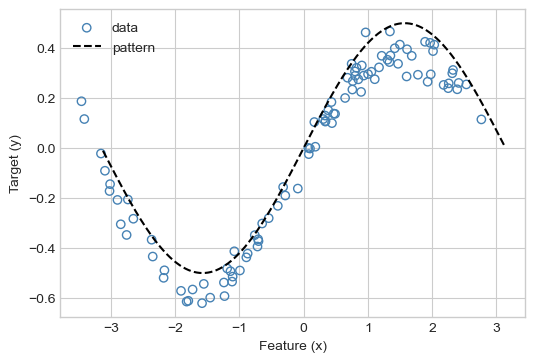

In [8]:
#---
X, y = regression_data(100, w, x_max=2*torch.pi, phi = torch.sin)
plot_regression_data(X, y, w, phi = torch.sin)
#---

As usual, we can apply a nonlinear feature map in order to be able to model this nonlinear pattern using techniques from convex linear models. First we'll implement a feature map for our data: 

In [9]:
#---
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree = 5)
phi = lambda X: torch.Tensor(pf.fit_transform(X))
#---

After computing the matrix of features, we can use our some ridge-regression solver from before: 

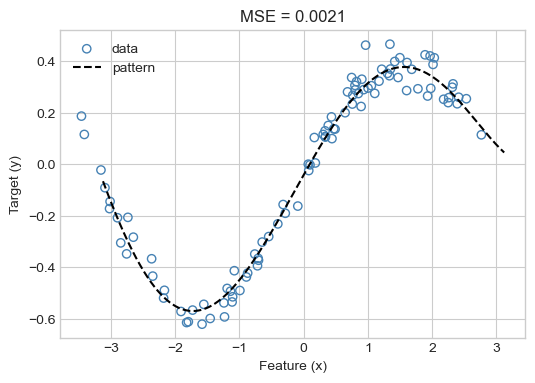

In [10]:
#---
PHI = phi(X)
w_hat = ridge_regression(PHI, y, lam = 1)
#---
plot_regression_data(X, y, w = w_hat, phi = phi, title = f"MSE = {mse(phi(X), y, w_hat):.4f}")

This looks like it works fine! Choosing polynomial features of too high a degree leads to problems at the boundaries, though: 

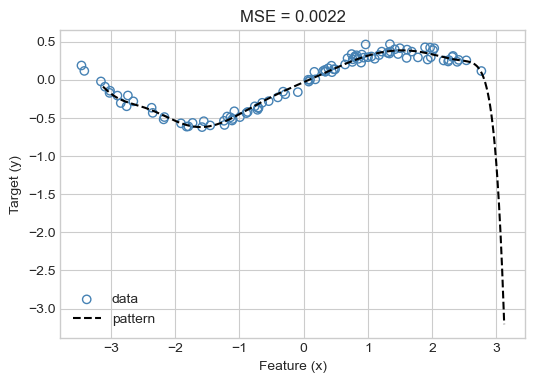

In [11]:
pf = PolynomialFeatures(degree = 15)
phi = lambda X: torch.Tensor(pf.fit_transform(X))
PHI = phi(X)
w_hat = ridge_regression(PHI, y, lam = 1)
plot_regression_data(X, y, w = w_hat, phi = phi, title = f"MSE = {mse(phi(X), y, w_hat):.4f}")

Although we can try to address this problem with further regularization, the results can be hard to predict: 

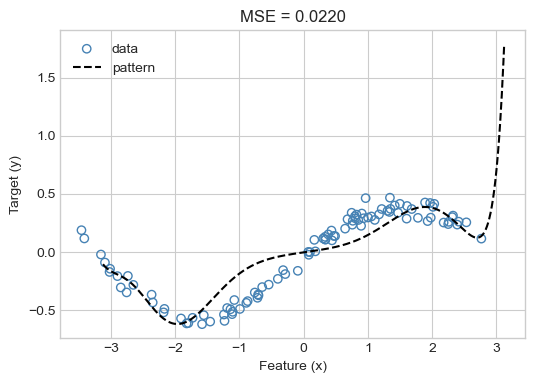

In [12]:
#---
w_hat = ridge_regression(PHI, y, lam = 100)
#---
plot_regression_data(X, y, w = w_hat, phi = phi, title = f"MSE = {mse(phi(X), y, w_hat):.4f}")

Hmmm, is that better? 



Here's a more systematic sweep in which we vary the both the regularization strength $\lambda$ and the degree of the polynomial features $d$. We fit the model using our ridge regression function above, and then evaluate the MSE on a test set. 

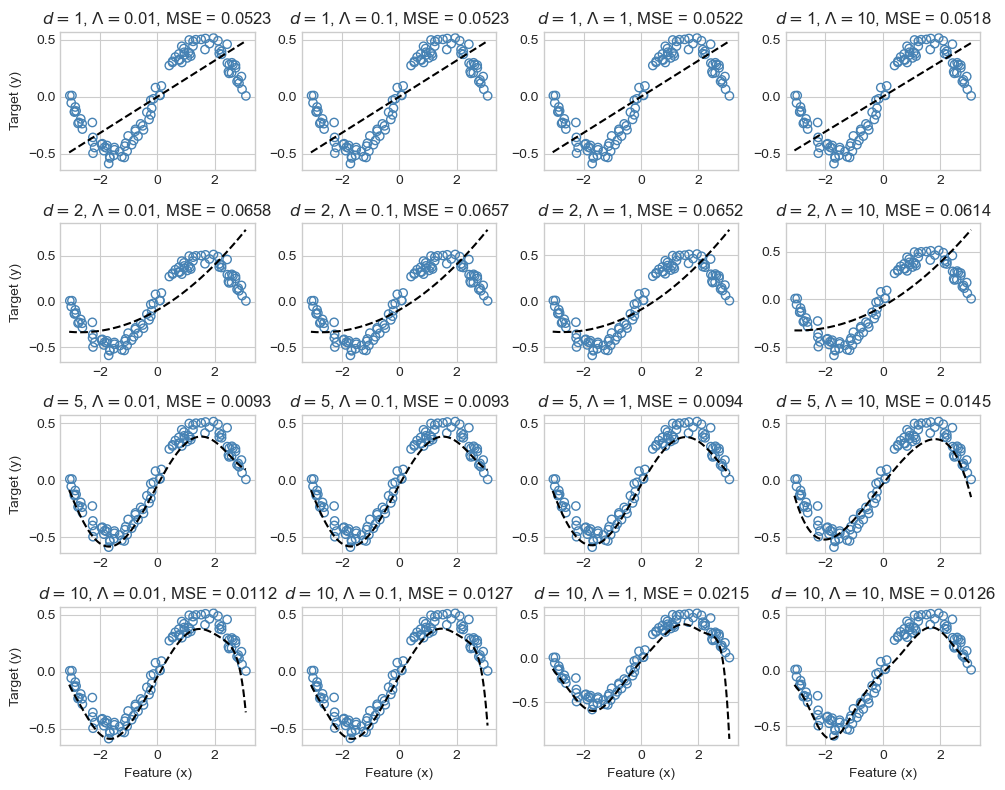

In [13]:
#| code-fold: true

# test set
X_test, y_test = regression_data(100, w, x_max=2*torch.pi, phi = torch.sin)

degrees = [1, 2, 5, 10]
LAM     = [0.01, 0.1, 1, 10, 100]

fig, ax = plt.subplots(4, 4, figsize = (10, 8))

# main loop
for i in range(4):
    for j in range(4): 
        pf = PolynomialFeatures(degree = degrees[i])
        phi = lambda X: torch.Tensor(pf.fit_transform(X))
        PHI = phi(X)
        w_hat = ridge_regression(PHI, y, lam = LAM[j])
        plot_regression_data(X_test, y_test, w = w_hat, phi = phi, ax = ax[i, j], legend = False, xlabel = i == 3, ylabel = j == 0)
        ax[i,j].set(title = fr"$d = ${degrees[i]}, $\Lambda = ${LAM[j]}, MSE = {mse(phi(X_test), y_test, w_hat):.4f}")

plt.tight_layout()

We observe that there is a "happy medium" for the choice of polynomial degree and regularization strength: degree-5 polynomial features with light regularization seem to perform best on unseen data. In most applications, these hyperparameters are selected using cross-validation. 

[Regression with polynomial features is not usually advised due to the strange behavior of the predictors at the boundary of the domain, which is on display in several of the plots above. We'll soon study kernel methods, which offer a preferable alternative to polynomial regression.]{.aside} 

## Computational Complexity

Is that all there is to least-squares linear regression? Of course not! 

### Other Regularizers

Not if we use different regularization terms! An especially popular regularizer is the $\ell_1$ regularizer that we [discussed previous](30-features-regularization.qmd). If we use this regularizer in addition to or instead of the $\ell_2$ regularization term, then we can't use the closed-form matrix formula above. 

### Kernels 

Using polynomial feature maps is not always ideal due to poor behavior at the data boundaries, but how else can we model nonlinearities in our data? We'll soon learn how to use *kernels* to introduce manageable nonlinearities. 

### Gradient Methods

More fundamentally, suppose that we have a *very* large number $p$ of features. The matrix $\Phi(\mathbf{X})^T\Phi(\mathbf{X}) + \lambda \mathbf{I}$ is a $p\times p$ matrix. The computational cost of *inverting* this matrix is $\Theta(n^\gamma)$ for some $\gamma$ between $2$ and $3$. For sufficiently large $p$, this may simply be infeasible. There are several approaches. 

To perform **gradient descent** with least-squares linear regression, all we need is a formula for the gradient. @eq-gradient gives this formula -- we just plug in the gradient of the regularizing term and iterate to convergence. 

Sometimes *even this* is too hard: for sufficiently large $p$, even computing the matrix multiplication $\Phi(\mathbf{X})^T\Phi(\mathbf{X})$ required for gradient descent is too computationally intensive. In this case, *stochastic* gradient methods can be used; we'll study these in a coming lecture. 
